# Cyber Threat Analyzer (CTA) - Part 1: Finding the Signal in the Noise

**Goal:** Ingest raw system log data, parse it into a structured format using Pandas and Regex, enrich it with threat intelligence from the AbuseIPDB API, and prepare it for exploratory data analysis (EDA).

### The "Why"
Raw log files are 99% routine system chatter or what we'll call "audio static". Hidden inside that noise is the 1% that truly matters: the "signal." This signal is our actionable intelligence - the failed logins, the weird connections, the real threats. The purpose of this notebook is to build the automatic noise filter. We'll use data engineering to turn that "wall of noise" into a clean, actionable signal, building the foundation for our ML model.

In [1]:
# This is the core library for building
# our data table (DataFrame).
import pandas as pd

# Pathlib makes it easy to build paths that work
# on multiple operating systems.
from pathlib import Path

# The Regular Expression library. This "pattern-matcher"
# will extract actionable data from the noise.
import re

# --- FIX: Add Project Root to Python Path ---
# We need to tell the notebook to look "one level up"
# to find our 'src' folder.
import sys
project_root = Path.cwd().parent
if str(project_root) not in sys.path:
    sys.path.append(str(project_root))
    print(f"Added project root to path: {project_root}")
# --- End Fix ---

# --- Import our new "toolboxes" ---
import src.data_processing as dp
import src.threat_intelligence as ti
import src.model as m

print("Import Complete")

Added project root to path: /Users/bg/projects/cta
Import Complete


## Step 2: Load API Key Securely

We need our AbuseIPDB API key to enrich the data. We load it securely from a `.env` file using the `python-dotenv` library. This is a critical security step that ensures our secret key is never accidentally "committed" and leaked on GitHub, where bots are constantly scanning for credentials.

In [2]:
import os
from dotenv import load_dotenv # Import the new library

# This line automatically finds the .env file in root
# and loads the variables found inside into the environment
# of this specific notebook session.
load_dotenv()

# This should now find the key
api_key = os.environ.get('ABUSEIPDB_KEY')

if api_key:
    print("Success! API Key loaded successfully from .env file.")
    # Optional: Verify the key looks right
    # print(f"   Key starts with: {api_key[:5]}... and ends with: {api_key[-5:]}")
else:
    print("Error: API Key not found.")
    print("   1. Did you create the `.env` file in the 'cta' root folder?")
    print("   2. Does the `.env` file contain 'ABUSEIPDB_KEY=your-key'?")
    print("   3. Did you install 'python-dotenv' (`pip install python-dotenv`)?")
    print("   4. Did you run the `load_dotenv()` command in this cell?")

Success! API Key loaded successfully from .env file.


In [3]:
# --- Phase 1: Run the Full Data Pipeline ---

# Define the path to our data
log_file_path = Path.cwd().parent / "data" / "system.log"

# --- 1. Load and Parse Logs ---
# This one function now does all of Step 1 from our old notebook
df = dp.load_and_parse_logs(log_file_path)

if not df.empty:
    # --- 2. Extract IP Addresses ---
    df['ip_address'] = df['message'].apply(ti.extract_ip)

    # --- 3. Build/Update Threat Intel Cache ---
    # Get a list of unique, non-null IPs to check
    unique_ips = df['ip_address'].dropna().unique()
    print(f"Found {len(unique_ips)} unique IPs to check.")
    
    # This function builds our cache and returns the intel
    ip_report_cache = ti.build_threat_cache(unique_ips, api_key)
    print("Threat intel cache build complete.")

    # --- 4. Engineer All Features (X and y) ---
    # This one function now does all of Step 3 from our old notebook
    df, X, y = dp.engineer_features(df, ip_report_cache)

    print("\n--- Full Data Pipeline Complete ---")
    df.head()
else:
    print("DataFrame is empty. Stopping pipeline.")

Starting log parsing from: /Users/bg/projects/cta/data/system.log
--- CTA Parser finished. Found 76 log entries. ---
Found 9 unique IPs to check.
Threat Intel Cache is up to date.
Threat intel cache build complete.
Engineering features for the model...
Feature engineering complete. X shape: (76, 5), y shape: (76,)

--- Full Data Pipeline Complete ---


In [4]:
# --- Phase 3: Run the ML "Brain" ---

if not df.empty:
    # --- 5. Train the Model ---
    # This one function splits the data and trains the "brain"
    model, X_test, y_test = m.train_model(X, y)

    # --- 6. Evaluate the Model ---
    # This one function runs the "final exam" and prints the report
    m.evaluate_model(model, X_test, y_test)
    
    print("\n--- Full ML Pipeline Complete ---")
else:
    print("DataFrame is empty. Skipping ML pipeline.")

Splitting data for training and testing...
Training set size: 60 logs
Test set size: 16 logs
--- Model Training Complete ---
Evaluating model performance on test data...

--- Classification Report ---
This report shows the model's ability to distinguish the Signal from the Noise.
              precision    recall  f1-score   support

   Noise (0)       0.64      0.78      0.70         9
  Signal (1)       0.60      0.43      0.50         7

    accuracy                           0.62        16
   macro avg       0.62      0.60      0.60        16
weighted avg       0.62      0.62      0.61        16


--- Confusion Matrix ---
This matrix shows the raw counts of correct and incorrect predictions.

--- Readable Confusion Matrix ---
                 PREDICTED
                 Noise (0)   Signal (1)
ACTUAL Noise (0)    7          2         
ACTUAL Signal (1)   4          3         

--- Model Evaluation Complete ---

--- Full ML Pipeline Complete ---


## Phase 2: Tuning In to the "Signal" (EDA)

We have successfully filtered the "static" and enriched our data. Our `df` DataFrame now contains the clean "signal".

The goal of this phase is to perform Exploratory Data Analysis (EDA). Before we can automate threat detection, we must first understand the signal ourselves. We will use visualizations to build a "Signal Report" that answers key questions:

1.  What is the overall tone of the logs? (e.g., mostly routine info, or full of errors?)
2.  When does the signal arrive? (e.g., are there spikes at certain hours?)
3.  Where is the signal coming from? (e.g., specific countries or high-risk IPs?)

### Step 2.1: Import Visualization Toolbox

First, we need to import our new display tools, `matplotlib` and `seaborn`. We'll also set a default theme to make our charts look clean and professional.

In [5]:
# Import visualization libraries
import matplotlib.pyplot as plt
import seaborn as sns

# Set a professional theme for our charts
sns.set_theme(style="darkgrid")

print("Visualization libraries imported and theme set.")

Visualization libraries imported and theme set.


### Step 2.2: Chart 1 - The "Log Level" Breakdown

Our first chart acts as a simple volume meter. It answers the question: "What is the overall tone of our logs?"

We will use a **countplot** to see the distribution of `log_level` categories. This gives us an immediate baseline. If 99% of logs are `INFO`, that is our normal static. A spike in `ERROR` or `WARNING` would be the first hint of a problem.

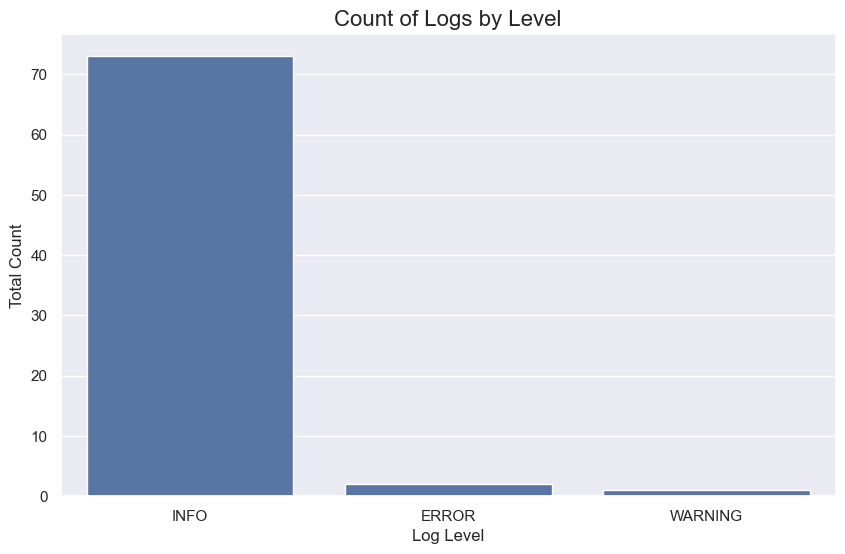

In [6]:
# Create a figure and set its size for better readability
plt.figure(figsize=(10, 6))

# Create the countplot
# We set 'order' to sort the bars from most frequent to least frequent
chart = sns.countplot(
    data=df,
    x='log_level',
    order=df['log_level'].value_counts().index
)

# Add clear titles and labels
chart.set_title('Count of Logs by Level', fontsize=16)
chart.set_xlabel('Log Level', fontsize=12)
chart.set_ylabel('Total Count', fontsize=12)

# Save the figure to a file
# This is for sharing our "Signal Report"
plt.savefig('01-log_level_distribution.png')

# Display the chart in the notebook
plt.show()

### Step 2.3: Chart 2 - Signal Timing (Logs by Hour)

Now we will investigate when the signals are arriving. This chart plots the total number of log entries for each hour of the day (0-23).

Think of this chart as a 24-hour audio equalizer (EQ). If the levels are all flat, it is just static (consistent activity). But if we see sharp spikes or dips, that is our waveform—a signal breaking through the noise. A huge spike at 3:00 AM, for instance, is a loud signal that strongly suggests automated attacks.

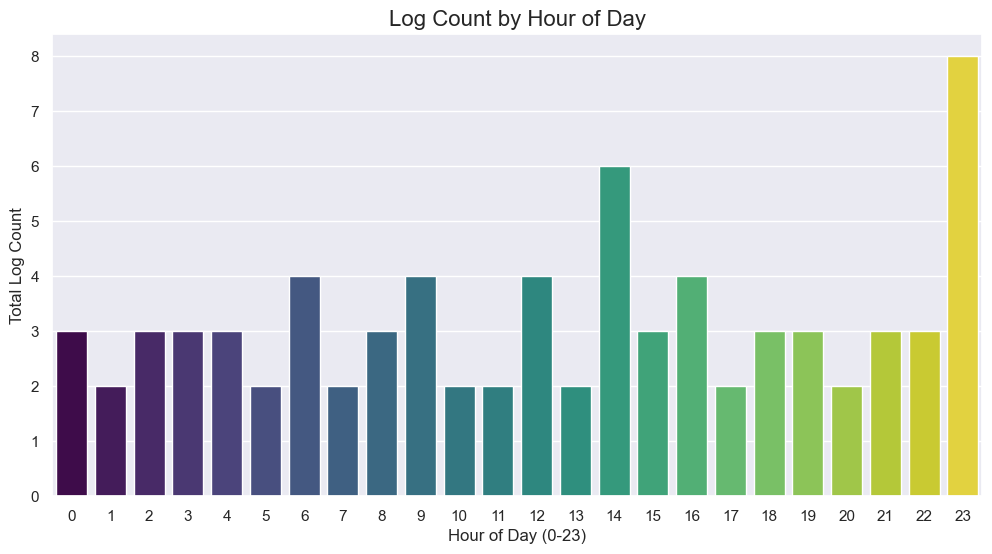

In [7]:
# Create a figure and set its size
plt.figure(figsize=(12, 6))

# Create the countplot for 'hour_of_day'
chart = sns.countplot(
    data=df,
    x='hour_of_day',
    # Explicitly map 'hour_of_day' to hue (color)
    hue='hour_of_day', 
    # Use our chosen color palette
    palette='viridis',
    # Turn off the legend, which is redundant for this chart
    legend=False 
)

# Add clear titles and labels
chart.set_title('Log Count by Hour of Day', fontsize=16)
chart.set_xlabel('Hour of Day (0-23)', fontsize=12)
chart.set_ylabel('Total Log Count', fontsize=12)

# Save the figure
plt.savefig('02-log_count_by_hour.png')

# Display the chart
plt.show()

### Step 2.4: Chart 3 - Threat Score Analysis (Abuse Score)

We have looked at our internal logs. Now it is time to look at the external threat intelligence we gathered. This chart answers: "Are the IPs in our logs harmless, or are they known threats?"

We will use a histogram for this. It groups the numeric `abuse_score` (0-100) into "bins" and counts how many IPs fall into each one.

This gives us an immediate "Threat Profile." We can see if our signal is mostly "noise" (IPs with a score of 0) or if it contains a clear "threat" (a spike of IPs with scores of 75+).

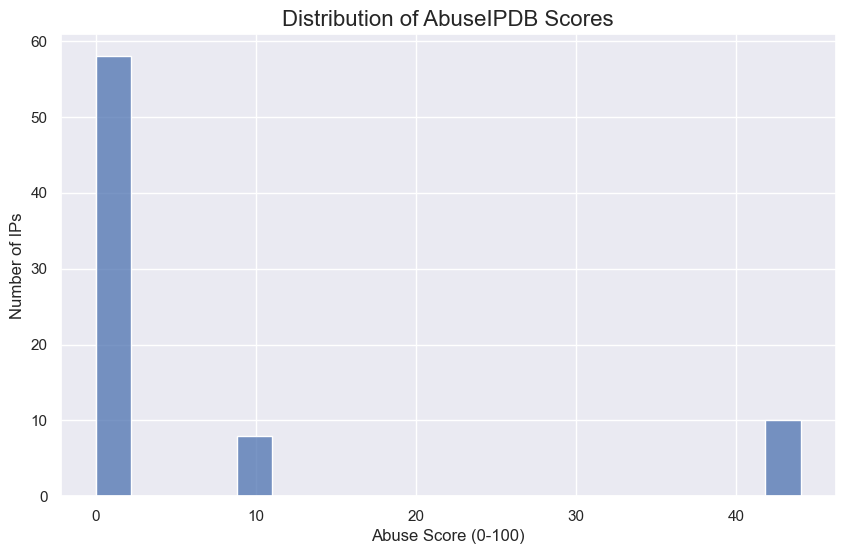

In [8]:
# Create a figure and set its size
plt.figure(figsize=(10, 6))

# Create the histogram
# We must .dropna() for this column, as we only want
# to plot the IPs that actually had a score.
chart = sns.histplot(
    data=df.dropna(subset=['abuse_score']), 
    x='abuse_score',
    bins=20,  # Group the 0-100 scores into 20 bars
    kde=False # We just want the bars, not a smoothed line
)

# Add clear titles and labels
chart.set_title('Distribution of AbuseIPDB Scores', fontsize=16)
chart.set_xlabel('Abuse Score (0-100)', fontsize=12)
chart.set_ylabel('Number of IPs', fontsize=12)

# Save the figure
plt.savefig('03-abuse_score_distribution.png')

# Display the chart
plt.show()

### Step 2.5: Chart 4 - Threat Map (Top Countries)

This is the final chart in our "Signal Report." It answers the geographic question: "Where in the world is the signal coming from?"

We will plot the total count of IPs by their source `country`. This helps us spot geographic patterns. A diverse map is normal. A massive spike from one or two specific countries, especially those with high abuse scores, is a strong indicator of a targeted or automated attack campaign.

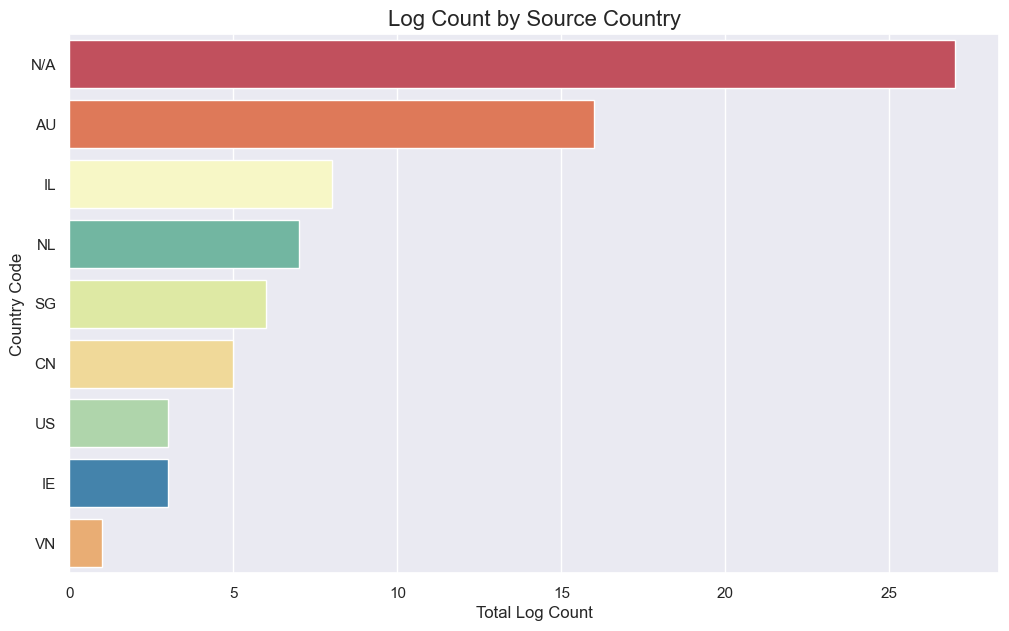

In [9]:
# Create a figure and set its size
plt.figure(figsize=(12, 7))

# Create the countplot for 'country'
# We want to plot only the IPs that *had* a country
# so we .dropna() first.
chart = sns.countplot(
    data=df.dropna(subset=['country']),
    y='country',      # Use 'y' for a horizontal bar chart
    hue='country',    # Explicitly map 'country' to hue (color)
    order=df['country'].value_counts().index,
    palette='Spectral',
    legend=False      # Turn off the legend
)

# Add clear titles and labels
chart.set_title('Log Count by Source Country', fontsize=16)
chart.set_xlabel('Total Log Count', fontsize=12)
chart.set_ylabel('Country Code', fontsize=12)

# Save the figure
plt.savefig('04-log_count_by_country.png')

# Display the chart
plt.show()